# imports

In [1]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import data_transforations as data_tr


## Models

In [101]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC



## Scoring

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Recall

In [ ]:
#cross_val_score(clf, X, y, cv=5, scoring='recall')

#cv= the number of folds in cross validation

### Precision

In [5]:
#cross_val_score(clf, X, y, cv=5, scoring='precision')

### F-beta 

F1 score but you can choose the weighting between recall and precision, where f1 is 50:50

In [6]:
#fbeta_scorer = make_scorer(fbeta_score, beta=2) 
#in model fitting: scoring=fbeta_scorer
##cross_val_score(clf, X, y, cv=5, scoring=fbeta_scorer)
# beta is the ratio of recall:precision, so beta=2 means rcall2:1precision and beta =0.5 means recall1:2precision

### Functions

In [70]:
def data_prep(path,features,target, filter=None):
    data=pd.DataFrame(pd.read_csv(path))
    data=data.drop(columns=['Unnamed: 0'])
    if filter is not None:
        data = data[data[filter].notnull()].copy()
    # impute missing values
    data['optionality'].fillna(0,inplace=True)
    data=pd.get_dummies(data,columns=['underwriting_outcome'],dummy_na=True, dtype=int)
    data=pd.get_dummies(data,columns=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'securitygroup_id', 'age_band', 'income_band',
       'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band'], dtype=int)
#dummy_na=True encodes NaN values into column,
#    only underwriting_outcome has significant number of missing values, which do indicate that underwritng was not required thus useful to know
    X = data[features].copy()
    Y = data[target].astype(int).copy()
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    return X_train, X_test, y_train, y_test


# Feature importance

In [ ]:
#all_features=['res_code_claims_sum', 'underwriting_outcome_nan',
#       'underwriting_outcome_Pending',
#       'total_funeral_premium_band_12.53 - 127.59',
#       'total_funeral_premium_band_< 12.53', 'funeral_count',
#       'benefits_count', 'total_funeral_premium_band_> 127.59',
#       'underwriting_outcome_Accidental Cover',
#       'last_benefit_amount_band_< 201014.05',
#       'sold_socio_economic_class_4.0', 'res_code_no interest_sum',
#       'res_code_QA_sum', 'duration_policy_start_delay',
#       'original_premium_band_> 519.78', 'securitygroup_id_MWL',
#       'res_code_other_sum', 'age_band_> 45.50',
#       'cover_amount_full_band_< 105015.62',
#       'last_benefit_amount_band_201014.05 - 526225.72', 'pml',
#       'last_benefit_amount_band_1050857.19 - 1485646.31',
#       'last_benefit_amount_band_> 1485646.31', 'age_band_< 29.50',
#       'sold_socio_economic_class_2.0',
#       'underwriting_outcome_Accepted with Loadings',
#       'original_premium_band_352.18 - 414.27',
#       'original_premium_band_< 236.86', 'age_band_29.50 - 33.50',
#       'cover_amount_full_band_105015.62 - 213181.66',
#       'original_premium_band_414.27 - 519.78', 'securitygroup_id_SD',
#       'education_Matric', 'education_Matric + 3 year Diploma',
#       '# calls contacted', 'income_band_29979.50 - 30050.00',
#       'original_premium_band_236.86 - 298.74',
#       'sold_socio_economic_class_3.0', 'education_No Matric',
#       'cover_amount_full_band_525032.38 - 1016188.00', 'eml',
#       'education_Matric + certificate', 'education_3 year Degree',
#       'res_code_payment_sum', 'optionality', 'smoker_status_E',
#       'gender_Female', 'education_4 year Degree',
#       'age_band_33.50 - 38.50', 'cover_amount_full_band_> 1016188.00',
#       'inflation', 'income_band_> 30050.00', '# calls',
#       'res_code_update_sum', 'res_code_sale_sum', 'unemployment rate',
#       'gender_Male', 'smoker_status_N', 'income_band_< 13842.50',
#       'underwriting_outcome_Accepted',
#       'last_benefit_amount_band_526225.72 - 1050857.19',
#       'smoker_status_S', 'age_band_38.50 - 45.50',
#       'cover_amount_full_band_213181.66 - 525032.38',
#       'res_code_quote_sum', 'sold_socio_economic_class_1.0',
#       'original_premium_band_298.74 - 352.18',
#       'education_Postgraduate Degree',
#       'education_Matric + 4 year Diploma',
#       'income_band_13842.50 - 29979.50']

## Loading data

In [7]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"
at_inception=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
at_inception=at_inception.drop(columns=['Unnamed: 0'])
at_inception.head()

,policy_name,education,gender,smoker_status,sold_socio_economic_class,underwriting_outcome,optionality,eml,pml,securitygroup_id,...,1month_lapse,3month_lapse,6month_lapse,ann_lapse,age_band,income_band,last_benefit_amount_band,cover_amount_full_band,total_funeral_premium_band,original_premium_band
0,MWL008050072,Matric,Male,S,1.0,NaN,0.0,0.00,0.0,MWL,...,0,0,0,0.0,> 45.50,> 30050.00,526225.72 - 1050857.19,525032.38 - 1016188.00,< 12.53,> 519.78
1,ML24-0199554,Matric + 3 year Diploma,Female,N,2.0,Accepted with Loadings,1.0,-0.05,0.0,MWL,...,0,0,0,0.0,< 29.50,13842.50 - 29979.50,> 1485646.31,> 1016188.00,< 12.53,236.86 - 298.74
2,ML24-0254853,Matric + 3 year Diploma,Female,E,1.0,Accepted with Loadings,1.0,0.60,0.0,MWL,...,0,0,0,NaN,> 45.50,> 30050.00,< 201014.05,< 105015.62,< 12.53,236.86 - 298.74
3,ML23-0067459,Matric + 3 year Diploma,Male,S,1.0,Accepted with Loadings,1.0,1.05,0.0,MWL,...,0,0,0,0.0,38.50 - 45.50,> 30050.00,< 201014.05,< 105015.62,< 12.53,< 236.86
4,MWL007912004,4 year Degree,Female,N,1.0,NaN,0.0,0.00,0.0,MWL,...,0,0,0,0.0,33.50 - 38.50,> 30050.00,1050857.19 - 1485646.31,213181.66 - 525032.38,> 127.59,352.18 - 414.27


## Hot-one encode all categorical data and dropping NaN values

In [8]:
# impute missing values
at_inception['optionality'].fillna(0,inplace=True)

C:\Users\E1005279\AppData\Local\Temp\ipykernel_22180\1760273001.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  at_inception['optionality'].fillna(0,inplace=True)


In [9]:
at_inception=pd.get_dummies(at_inception,columns=['underwriting_outcome'],dummy_na=True, dtype=int)
at_inception=pd.get_dummies(at_inception,columns=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'securitygroup_id', 'age_band', 'income_band',
       'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band'], dtype=int)
#dummy_na=True encodes NaN values into column,
#    only underwriting_outcome has significant number of missing values, which do indicate that underwritng was not required thus useful to know

In [ ]:
cols=set(at_inception.columns)
column_excl = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name']
features=list(cols.difference(column_excl))


## Lapse feature importance

In [ ]:
target='lapse_flag'
X_lapse = at_inception[features].copy()
Y_lapse = at_inception[target].astype(int).copy()
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lapse, Y_lapse, test_size=0.20, random_state=42, stratify=Y_lapse)



IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 1, 0.1)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso(max_iter=5000)

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_train, y_train)
print("Best Params {}".format(lasso_cv.best_params_))


: 

: 

In [41]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+02, tolerance: 4.434e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
feat_imp=pd.DataFrame({'feature':X_train.columns, 'imp score':lasso1_coef})
feat_imp.sort_values(by='imp score', ascending=False, inplace=True)
feat_imp
#70 features (after onehot-encoding)
#underwriting_outcome
#total_funeral_premium_band
#duration_policy_start_delay
#secutiygroup_id
#SEC
#res_code (QA and quote)
#benefits_count
#last_benefit_amount_band
#funeral_count
#cover_amount_full_band (highest and lowest)
#orginal_premium_band (lowest)
#age_band (oldest)
#pml
#inflation

#imp_features=['original_premium_band_352.18 - 414.27',
# 'last_benefit_amount_band_> 1485646.31',
# 'last_benefit_amount_band_201014.05 - 526225.72',
# 'cover_amount_full_band_525032.38 - 1016188.00',
# 'pml',
# 'sold_socio_economic_class_3.0',
# 'last_benefit_amount_band_526225.72 - 1050857.19',
# 'total_funeral_premium_band_> 127.59',
# 'age_band_< 29.50',
# 'last_benefit_amount_band_1050857.19 - 1485646.31',
# 'securitygroup_id_SD',
# 'original_premium_band_< 236.86',
# 'cover_amount_full_band_105015.62 - 213181.66',
# 'age_band_38.50 - 45.50',
# 'underwriting_outcome_nan',
#'original_premium_band_> 519.78',
# 'cover_amount_full_band_< 105015.62',
# 'underwriting_outcome_Accepted with Loadings',
# 'age_band_33.50 - 38.50',
# 'last_benefit_amount_band_< 201014.05',
# 'res_code_quote_sum',
# 'res_code_no interest_sum',
# 'sold_socio_economic_class_1.0',
# 'cover_amount_full_band_213181.66 - 525032.38',
# 'inflation',
# 'res_code_QA_sum',
# 'funeral_count',
# 'original_premium_band_298.74 - 352.18',
# 'original_premium_band_236.86 - 298.74',
# 'total_funeral_premium_band_< 12.53',
# 'res_code_update_sum',
# 'underwriting_outcome_Accidental Cover',
# 'sold_socio_economic_class_4.0',
# 'underwriting_outcome_Accepted',
# 'underwriting_outcome_Pending',
# 'benefits_count',
# 'duration_policy_start_delay',
# 'sold_socio_economic_class_2.0',
# 'securitygroup_id_MWL',
# 'age_band_29.50 - 33.50',
# 'age_band_> 45.50',
# 'total_funeral_premium_band_12.53 - 127.59',
# 'cover_amount_full_band_> 1016188.00',
# 'original_premium_band_414.27 - 519.78']


,feature,imp score
51,underwriting_outcome_Pending,0.284809
24,underwriting_outcome_nan,0.248262
9,total_funeral_premium_band_> 127.59,0.190369
56,duration_policy_start_delay,0.158176
30,last_benefit_amount_band_< 201014.05,0.154329
...,...,...
37,smoker_status_N,0.000000
29,age_band_33.50 - 38.50,0.000000
28,underwriting_outcome_Accepted with Loadings,0.000000
16,res_code_claims_sum,0.000000


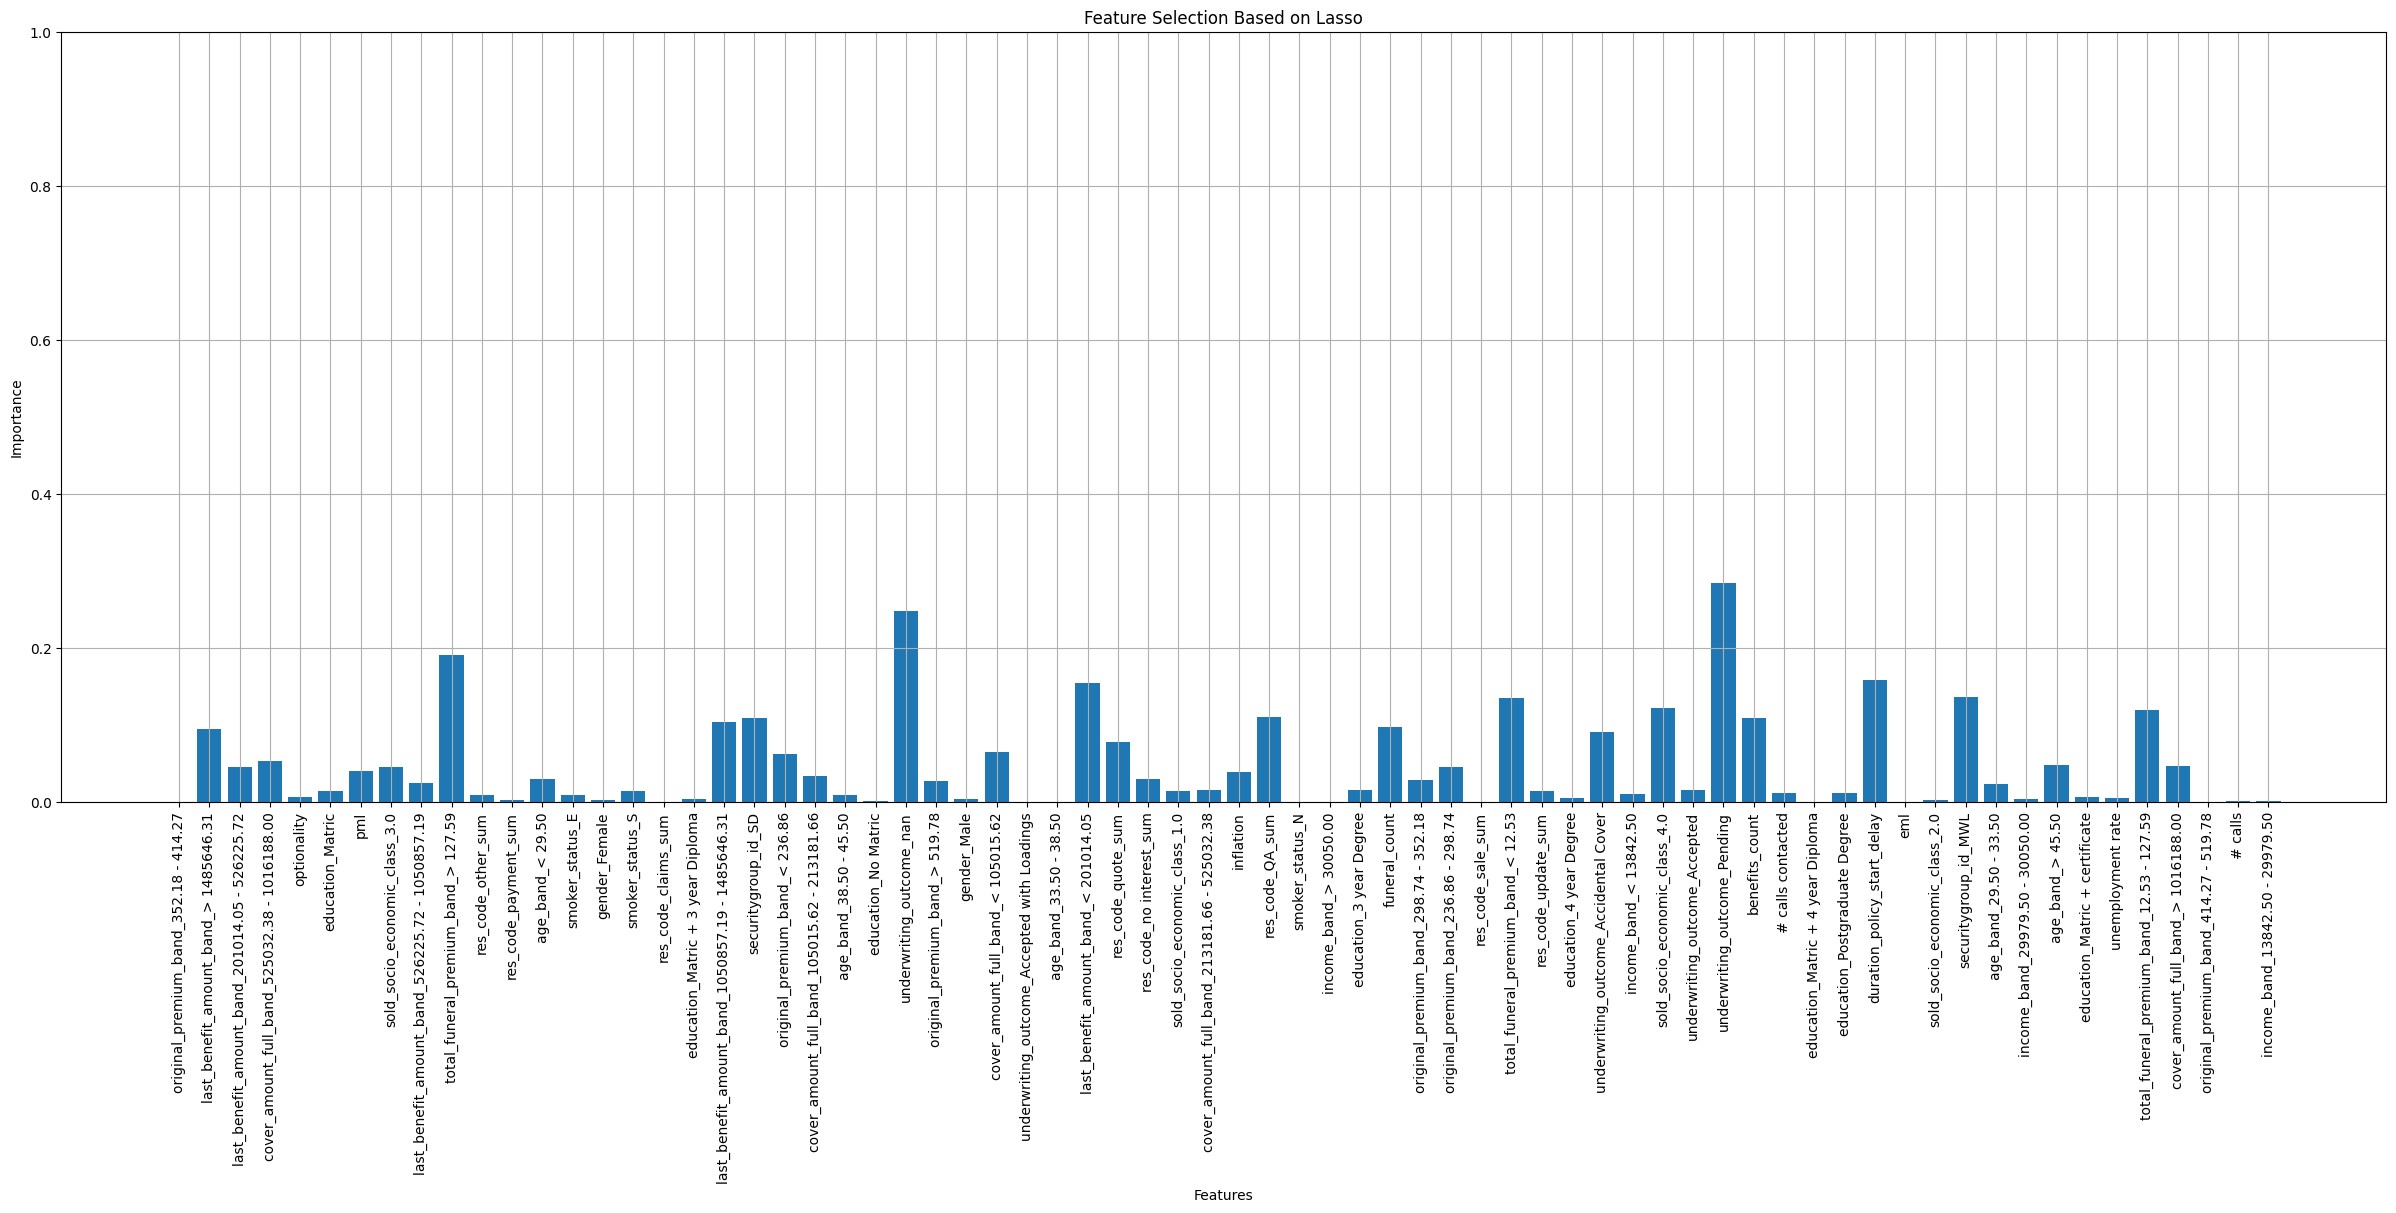

In [14]:

# plotting the Column Names and Importance of Columns. 
plt.figure(figsize=(30, 10))
plt.bar(X_train.columns, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 1)

plt.show()

In [65]:
lapse_feature=['original_premium_band_352.18 - 414.27',
 'last_benefit_amount_band_> 1485646.31',
 'last_benefit_amount_band_201014.05 - 526225.72',
 'cover_amount_full_band_525032.38 - 1016188.00',
 'pml',
 'sold_socio_economic_class_3.0',
 'last_benefit_amount_band_526225.72 - 1050857.19',
 'total_funeral_premium_band_> 127.59',
 'age_band_< 29.50',
 'last_benefit_amount_band_1050857.19 - 1485646.31',
 'securitygroup_id_SD',
 'original_premium_band_< 236.86',
 'cover_amount_full_band_105015.62 - 213181.66',
 'age_band_38.50 - 45.50',
 'underwriting_outcome_nan',
'original_premium_band_> 519.78',
 'cover_amount_full_band_< 105015.62',
 'underwriting_outcome_Accepted with Loadings',
 'age_band_33.50 - 38.50',
 'last_benefit_amount_band_< 201014.05',
 'res_code_quote_sum',
 'res_code_no interest_sum',
 'sold_socio_economic_class_1.0',
 'cover_amount_full_band_213181.66 - 525032.38',
 'inflation',
 'res_code_QA_sum',
 'funeral_count',
 'original_premium_band_298.74 - 352.18',
 'original_premium_band_236.86 - 298.74',
 'total_funeral_premium_band_< 12.53',
 'res_code_update_sum',
 'underwriting_outcome_Accidental Cover',
 'sold_socio_economic_class_4.0',
 'underwriting_outcome_Accepted',
 'underwriting_outcome_Pending',
 'benefits_count',
 'duration_policy_start_delay',
 'sold_socio_economic_class_2.0',
 'securitygroup_id_MWL',
 'age_band_29.50 - 33.50',
 'age_band_> 45.50',
 'total_funeral_premium_band_12.53 - 127.59',
 'cover_amount_full_band_> 1016188.00',
 'original_premium_band_414.27 - 519.78']

## 1 Month lapse fetaure importance

In [44]:
target='1month_lapse'
X_lapse = at_inception[features].copy()
Y_lapse = at_inception[target].astype(int).copy()
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lapse, Y_lapse, test_size=0.20, random_state=42, stratify=Y_lapse)
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

feat_imp=pd.DataFrame({'feature':X_train.columns, 'imp score':lasso1_coef})
feat_imp.sort_values(by='imp score', ascending=False, inplace=True)
feat_imp

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.879e+02, tolerance: 1.905e-01
  model = cd_fast.enet_coordinate_descent(


,feature,imp score
16,res_code_claims_sum,0.120470
24,underwriting_outcome_nan,0.097057
51,underwriting_outcome_Pending,0.093134
65,total_funeral_premium_band_12.53 - 127.59,0.072296
44,total_funeral_premium_band_< 12.53,0.071889
...,...,...
33,sold_socio_economic_class_1.0,0.000000
41,original_premium_band_298.74 - 352.18,0.000000
55,education_Postgraduate Degree,0.000000
54,education_Matric + 4 year Diploma,0.000000


In [49]:
#res_code (claims)
#underwriting outcome
#funeral premium
#funeral count
#benefit count
#last benefit amount
#sec
#res_code no interest, QA, other
#duration policy start delay
#premium
#security ExceptionGroup
#age
#cover amount
#pml


m1_feature=['res_code_claims_sum', 'underwriting_outcome_nan',
       'underwriting_outcome_Pending',
       'total_funeral_premium_band_12.53 - 127.59',
       'total_funeral_premium_band_< 12.53', 'funeral_count',
       'benefits_count', 'total_funeral_premium_band_> 127.59',
       'underwriting_outcome_Accidental Cover',
       'last_benefit_amount_band_< 201014.05',
       'sold_socio_economic_class_4.0', 'res_code_no interest_sum',
       'res_code_QA_sum', 'duration_policy_start_delay',
       'original_premium_band_> 519.78', 'securitygroup_id_MWL',
       'res_code_other_sum', 'age_band_> 45.50',
       'cover_amount_full_band_< 105015.62',
       'last_benefit_amount_band_201014.05 - 526225.72', 'pml',
       'last_benefit_amount_band_1050857.19 - 1485646.31',
       'last_benefit_amount_band_> 1485646.31', 'age_band_< 29.50',
       'sold_socio_economic_class_2.0',
       'underwriting_outcome_Accepted with Loadings',
       'original_premium_band_352.18 - 414.27',
       'original_premium_band_< 236.86', 'age_band_29.50 - 33.50',
       'cover_amount_full_band_105015.62 - 213181.66',
       'original_premium_band_414.27 - 519.78', 'securitygroup_id_SD',
       'original_premium_band_236.86 - 298.74',
       'sold_socio_economic_class_3.0',
       'cover_amount_full_band_525032.38 - 1016188.00',
       'age_band_33.50 - 38.50', 'cover_amount_full_band_> 1016188.00',
       'underwriting_outcome_Accepted',
       'last_benefit_amount_band_526225.72 - 1050857.19',
       'age_band_38.50 - 45.50',
       'cover_amount_full_band_213181.66 - 525032.38',
       'sold_socio_economic_class_1.0',
       'original_premium_band_298.74 - 352.18']

## 3 month lapse feature importance

In [50]:
target='3month_lapse'
X_lapse = at_inception[features].copy()
Y_lapse = at_inception[target].astype(int).copy()
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lapse, Y_lapse, test_size=0.20, random_state=42, stratify=Y_lapse)
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

feat_imp=pd.DataFrame({'feature':X_train.columns, 'imp score':lasso1_coef})
feat_imp.sort_values(by='imp score', ascending=False, inplace=True)
feat_imp

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+03, tolerance: 3.305e-01
  model = cd_fast.enet_coordinate_descent(


,feature,imp score
31,res_code_quote_sum,0.192924
24,underwriting_outcome_nan,0.180684
51,underwriting_outcome_Pending,0.176904
65,total_funeral_premium_band_12.53 - 127.59,0.144889
44,total_funeral_premium_band_< 12.53,0.141268
...,...,...
29,age_band_33.50 - 38.50,0.000000
33,sold_socio_economic_class_1.0,0.000000
34,cover_amount_full_band_213181.66 - 525032.38,0.000000
37,smoker_status_N,0.000000


In [51]:
#res_code quote, claim, QA, no interest, other
#underwriting
#funreal premium
#funeral count
#benefits count
#duration policy start delay
#SEC
#securitygroup_id
#pml
#age
#premium
#cover amount


m3_feature=['res_code_claims_sum', 'underwriting_outcome_nan',
       'underwriting_outcome_Pending',
       'total_funeral_premium_band_12.53 - 127.59',
       'total_funeral_premium_band_< 12.53', 'funeral_count',
       'benefits_count', 'total_funeral_premium_band_> 127.59',
       'underwriting_outcome_Accidental Cover',
       'last_benefit_amount_band_< 201014.05',
       'sold_socio_economic_class_4.0', 'res_code_no interest_sum',
       'res_code_QA_sum', 'duration_policy_start_delay',
       'original_premium_band_> 519.78', 'securitygroup_id_MWL',
       'res_code_other_sum', 'age_band_> 45.50',
       'cover_amount_full_band_< 105015.62',
       'last_benefit_amount_band_201014.05 - 526225.72', 'pml',
       'last_benefit_amount_band_1050857.19 - 1485646.31',
       'last_benefit_amount_band_> 1485646.31', 'age_band_< 29.50',
       'sold_socio_economic_class_2.0',
       'underwriting_outcome_Accepted with Loadings',
       'original_premium_band_352.18 - 414.27',
       'original_premium_band_< 236.86', 'age_band_29.50 - 33.50',
       'cover_amount_full_band_105015.62 - 213181.66',
       'original_premium_band_414.27 - 519.78', 'securitygroup_id_SD',
       'original_premium_band_236.86 - 298.74',
       'sold_socio_economic_class_3.0', 
       'cover_amount_full_band_525032.38 - 1016188.00',
       'age_band_33.50 - 38.50', 'cover_amount_full_band_> 1016188.00',
       'underwriting_outcome_Accepted',
       'last_benefit_amount_band_526225.72 - 1050857.19',
       'age_band_38.50 - 45.50',
       'cover_amount_full_band_213181.66 - 525032.38',
       'res_code_quote_sum', 'sold_socio_economic_class_1.0',
       'original_premium_band_298.74 - 352.18']

## 6 month lapse feature importance

In [52]:
target='6month_lapse'
X_lapse = at_inception[features].copy()
Y_lapse = at_inception[target].astype(int).copy()
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lapse, Y_lapse, test_size=0.20, random_state=42, stratify=Y_lapse)
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

feat_imp=pd.DataFrame({'feature':X_train.columns, 'imp score':lasso1_coef})
feat_imp.sort_values(by='imp score', ascending=False, inplace=True)
feat_imp

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+02, tolerance: 4.434e-01
  model = cd_fast.enet_coordinate_descent(


,feature,imp score
24,underwriting_outcome_nan,0.249263
51,underwriting_outcome_Pending,0.245538
31,res_code_quote_sum,0.146620
59,securitygroup_id_MWL,0.137394
56,duration_policy_start_delay,0.135838
...,...,...
29,age_band_33.50 - 38.50,0.000000
28,underwriting_outcome_Accepted with Loadings,0.000000
26,gender_Male,0.000000
19,securitygroup_id_SD,0.000000


In [53]:
#underwriting outcome
#res_code quote, QA, no interest, claims
#security group
#duration
#last benefit
#sec
# cover
# age
#funeral premium
#pml
#premium
#funeral count


m6_feature=['res_code_claims_sum', 'underwriting_outcome_nan',
       'underwriting_outcome_Pending',
       'total_funeral_premium_band_12.53 - 127.59',
       'total_funeral_premium_band_< 12.53', 'funeral_count',
       'total_funeral_premium_band_> 127.59',
       'underwriting_outcome_Accidental Cover',
       'last_benefit_amount_band_< 201014.05',
       'sold_socio_economic_class_4.0', 'res_code_no interest_sum',
       'res_code_QA_sum', 'duration_policy_start_delay',
       'original_premium_band_> 519.78', 'securitygroup_id_MWL',
       'age_band_> 45.50',
       'cover_amount_full_band_< 105015.62',
       'last_benefit_amount_band_201014.05 - 526225.72', 'pml',
       'last_benefit_amount_band_1050857.19 - 1485646.31',
       'last_benefit_amount_band_> 1485646.31', 'age_band_< 29.50',
       'sold_socio_economic_class_2.0',
       'underwriting_outcome_Accepted with Loadings',
       'original_premium_band_352.18 - 414.27',
       'original_premium_band_< 236.86', 'age_band_29.50 - 33.50',
       'cover_amount_full_band_105015.62 - 213181.66',
       'original_premium_band_414.27 - 519.78', 'securitygroup_id_SD',
       'original_premium_band_236.86 - 298.74',
       'sold_socio_economic_class_3.0', 
       'cover_amount_full_band_525032.38 - 1016188.00', 
       'age_band_33.50 - 38.50', 'cover_amount_full_band_> 1016188.00',
       'underwriting_outcome_Accepted',
       'last_benefit_amount_band_526225.72 - 1050857.19',
       'age_band_38.50 - 45.50',
       'cover_amount_full_band_213181.66 - 525032.38',
       'res_code_quote_sum', 'sold_socio_economic_class_1.0',
       'original_premium_band_298.74 - 352.18']

## anniversary lapse feature importance

In [55]:
target='ann_lapse'
at_inception_ann = at_inception[at_inception['ann_lapse'].notnull()].copy()
X_lapse = at_inception_ann[features].copy()
Y_lapse = at_inception_ann[target].astype(int).copy()
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lapse, Y_lapse, test_size=0.20, random_state=42, stratify=Y_lapse)
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

feat_imp=pd.DataFrame({'feature':X_train.columns, 'imp score':lasso1_coef})
feat_imp.sort_values(by='imp score', ascending=False, inplace=True)
feat_imp

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.691e+02, tolerance: 1.199e-01
  model = cd_fast.enet_coordinate_descent(


,feature,imp score
56,duration_policy_start_delay,0.050730
49,sold_socio_economic_class_4.0,0.048423
51,underwriting_outcome_Pending,0.036173
24,underwriting_outcome_nan,0.030721
6,pml,0.029164
...,...,...
58,sold_socio_economic_class_2.0,0.000000
31,res_code_quote_sum,0.000000
19,securitygroup_id_SD,0.000000
47,underwriting_outcome_Accidental Cover,0.000000


In [57]:




ann_feature=['underwriting_outcome_nan',
       'underwriting_outcome_Pending',
       'total_funeral_premium_band_12.53 - 127.59',
       'total_funeral_premium_band_< 12.53', 'funeral_count',
       'benefits_count', 'total_funeral_premium_band_> 127.59',
       'underwriting_outcome_Accidental Cover',
       'last_benefit_amount_band_< 201014.05',
       'sold_socio_economic_class_4.0', 'res_code_no interest_sum',
       'res_code_QA_sum', 'duration_policy_start_delay',
       'original_premium_band_> 519.78', 'securitygroup_id_MWL',
       'res_code_other_sum', 'age_band_> 45.50',
       'cover_amount_full_band_< 105015.62',
       'last_benefit_amount_band_201014.05 - 526225.72', 'pml',
       'last_benefit_amount_band_1050857.19 - 1485646.31',
       'last_benefit_amount_band_> 1485646.31', 'age_band_< 29.50',
       'sold_socio_economic_class_2.0',
       'underwriting_outcome_Accepted with Loadings',
       'original_premium_band_352.18 - 414.27',
       'original_premium_band_< 236.86', 'age_band_29.50 - 33.50',
       'cover_amount_full_band_105015.62 - 213181.66',
       'original_premium_band_414.27 - 519.78', 'securitygroup_id_SD',
       'income_band_29979.50 - 30050.00',
       'original_premium_band_236.86 - 298.74',
       'sold_socio_economic_class_3.0',
       'cover_amount_full_band_525032.38 - 1016188.00',
       'res_code_payment_sum',
       'age_band_33.50 - 38.50', 'cover_amount_full_band_> 1016188.00',
       'inflation', 'income_band_> 30050.00',
       'res_code_update_sum', 'res_code_sale_sum', 'unemployment rate',
       'income_band_< 13842.50',
       'underwriting_outcome_Accepted',
       'last_benefit_amount_band_526225.72 - 1050857.19',
        'age_band_38.50 - 45.50',
       'cover_amount_full_band_213181.66 - 525032.38',
       'sold_socio_economic_class_1.0',
       'original_premium_band_298.74 - 352.18',
       'income_band_13842.50 - 29979.50']

# Modelling

Target = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag']

### Data for modeling

In [66]:
imp_features=lapse_feature
target='lapse_flag'
#filter='ann_lapse'


In [71]:
X_train,x_test, Y_train, y_test = data_prep(path+"inception_data_eco_v3.csv",imp_features,target)

C:\Users\E1005279\AppData\Local\Temp\ipykernel_22180\1216123453.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['optionality'].fillna(0,inplace=True)


### Random Forest

In [ ]:
X_train.shape

(51161,)

In [ ]:
b=4 #ratio of recall to precision
#getting best params
param_dist = {'n_estimators': randint(50,500),
              'min_samples_leaf': randint(1000,4000)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring='recall', random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002758F581130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002758F5AEFC0>},
                   random_state=42, scoring='recall')

best score 0.08338059112331951
 best eatimator RandomForestClassifier(min_samples_leaf=1021, n_estimators=302)
 best params {'min_samples_leaf': 1021, 'n_estimators': 302}
 


In [100]:
n_estimators=302
min_samples_leaf=1021
rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42)
recall = cross_val_score(rfc, X_train, Y_train, cv=5, scoring='recall')
precision = cross_val_score(rfc,X_train, Y_train, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(rfc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')


recall score [0.08517609 0.07619828 0.08353808 0.08640459 0.07616708]
 precision score [0.72473868 0.75       0.68918919 0.62611276 0.80172414]
 f beta score [0.08983968 0.08044983 0.08809185 0.09101982 0.08044983]


In [102]:
rfc.fit(X_train.copy(),Y_train.copy())
y_pred = rfc.predict(x_test)

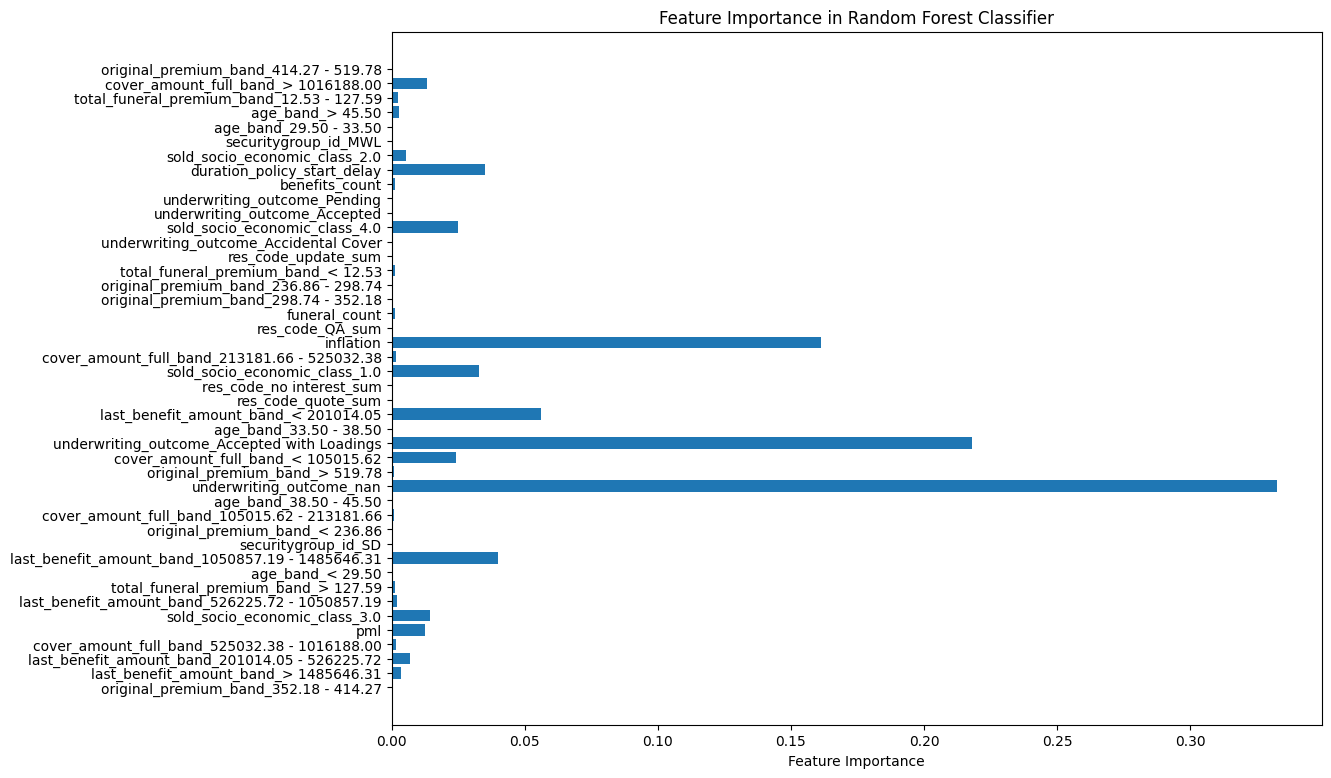

In [103]:
feature_importances =rfc.feature_importances_
plt.figure(figsize=(12, 9)) 
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

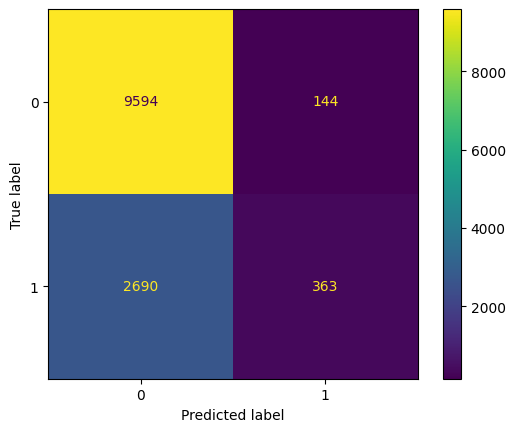

In [104]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


### try resampling SMOTE

In [114]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(sampling_strategy=0.35,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())

In [117]:
b=4 #ratio of recall to precision
#getting best params
param_dist = {'n_estimators': randint(50,500),
              'min_samples_leaf': randint(1000,4000)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring='recall', random_state=42)

# Fit the random search object to the data
rand_search.fit(X_smote, Y_smote)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

best score 0.17472335152321786
 best eatimator RandomForestClassifier(min_samples_leaf=1021, n_estimators=302)
 best params {'min_samples_leaf': 1021, 'n_estimators': 302}
 


### XGBoost

In [ ]:
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(1000,2000),
              'learning_rate': randint(0,2),
              'max_depth': randint(3,5)}

# Create a random forest classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=fbeta_scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027588EC0710>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027588EC0500>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002758F592510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027590243EF0>},
                   random_state=42, scoring='recall')

In [107]:
print(rand_search.best_params_ )
print(rand_search.best_score_)

{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1021, 'n_estimators': 285}
0.4039640847506476


In [108]:
n_estimators=285
learning_rate = 1
max_depth = 4
min_samples_leaf=1021
xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

recall = cross_val_score(xgbc, X_train, Y_train, cv=5, scoring='recall')
precision = cross_val_score(xgbc,X_train, Y_train, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(xgbc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

recall score [0.41646192 0.40147481 0.3980344  0.39107289 0.41277641]
 precision score [0.69993118 0.70605187 0.69230769 0.68068425 0.7       ]
 f beta score [0.42662554 0.4119276  0.40824192 0.4011118  0.42298578]


In [109]:
xgbc.fit(X_train.copy(),Y_train.copy())
y_pred = xgbc.predict(x_test)


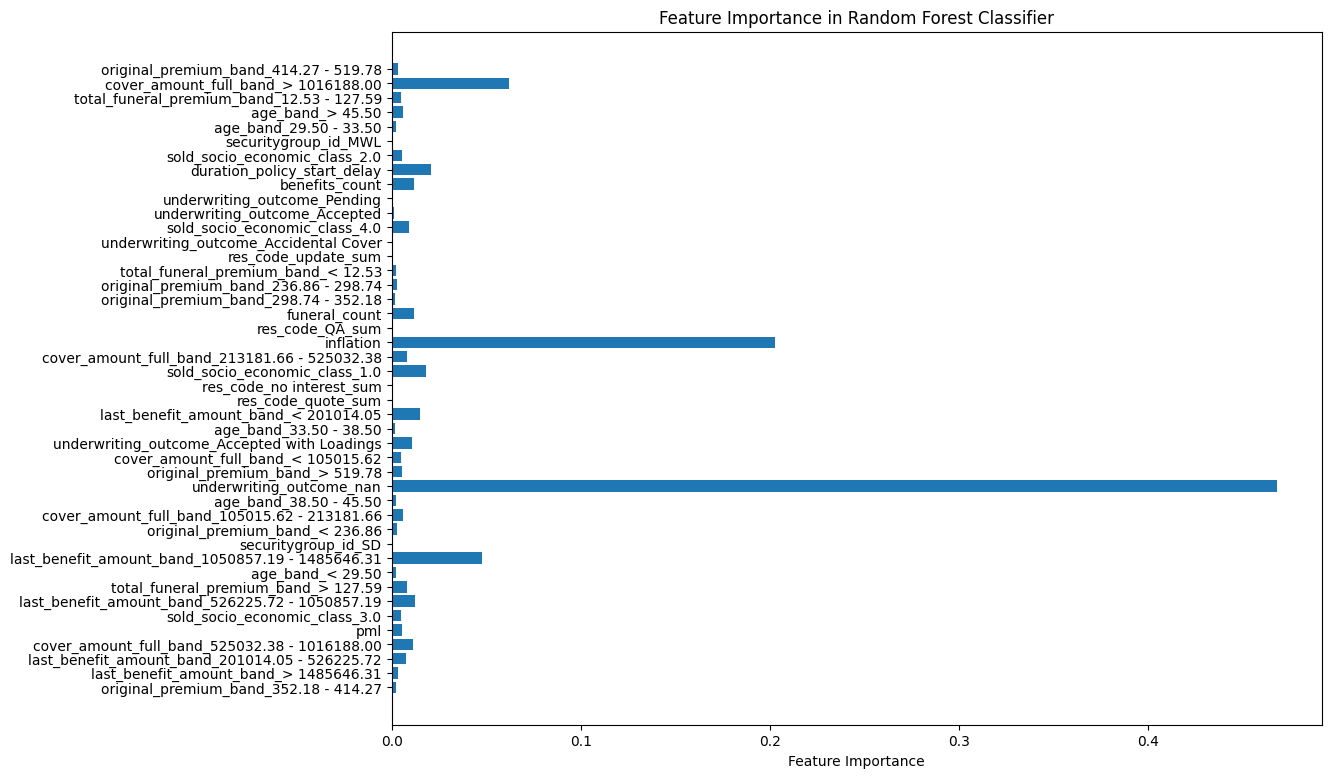

In [110]:
feature_importances =xgbc.feature_importances_
plt.figure(figsize=(12, 9)) 
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

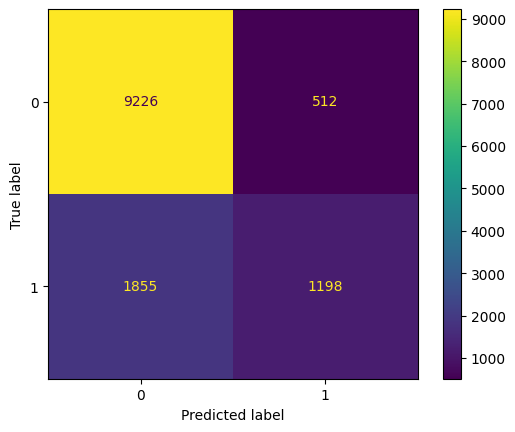

In [111]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### SVM

In [120]:
from scipy.stats import loguniform

In [121]:
b=4 #ratio of recall to precision
#getting best params
param_dist = {'C': loguniform(1e-3, 1e2),
              'gamma': loguniform(1e-4, 1e-1)}

# Create a random forest classifier
sv = SVC()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(sv, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring='recall', random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')







KeyboardInterrupt: 

In [123]:
gamma=0.1
C = 5
svc = SVC(gamma=gamma, C=C, random_state=42)
recall = cross_val_score(svc, X_train, Y_train, cv=5, scoring='recall')
precision = cross_val_score(svc,X_train, Y_train, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(svc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

KeyboardInterrupt: 

In [ ]:
svc.fit(X_train.copy(),Y_train.copy())
y_pred = svc.predict(x_test)

In [ ]:
feature_importances =svc.feature_importances_
plt.figure(figsize=(12, 9)) 
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### NN

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
b=4 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['lbfgs', 'adam','sgd'],
              'alpha': loguniform(1e-5, 1e-2),
              'hidden_layer_sizes': [(10,), (15,), (20,), (25,)]}


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring='recall', random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

In [ ]:
solver='lbfgs'
alpha=1e-5
hidden_layer_sizes=(15,)

mlpc = MLPClassifier(solver=solver, alpha=alpha,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)
recall = cross_val_score(mlpc, X_train, Y_train, cv=5, scoring='recall')
precision = cross_val_score(mlpc,X_train, Y_train, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(mlpc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

In [ ]:
mlpc.fit(X_train.copy(),Y_train.copy())
y_pred = mlpc.predict(x_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()